<a href="https://colab.research.google.com/github/rineuman/GB2020/blob/master/Gro%C3%9FerBeleg2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALL LIBRARIES

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip install q keras==2.1

In [3]:
!pip install imgaug
!pip install Cython
!pip install pycocotools
!pip install kaggle

CLONE MATTERPORT REPOSITORY

In [4]:
!git clone https://github.com/matterport/Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [5]:
! pwd

/content


In [0]:
import os 
os.chdir('Mask_RCNN')

In [7]:
!git clone https://github.com/rineuman/barrierDataset.git

fatal: destination path 'barrierDataset' already exists and is not an empty directory.


In [0]:
os.chdir('samples')

In [9]:
import sys
import random
import math
import re
import time
import json
import skimage.draw
import numpy as np
import cv2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "barrierDataset/val")

Using TensorFlow backend.


CONFIGURATION

In [10]:
class BarrierConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "barrier"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 barriers

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    # IMAGE_MIN_DIM = 128
    # IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1

    # use small validation steps since the epoch is small
    # VALIDATION_STEPS = 5
    
config = BarrierConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

DATASET

In [0]:
class BarrierDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_barrier(self, dataset_dir, subset):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("barrier", 1, "door")
        self.add_class("barrier", 2, "stair")
        self.add_class("barrier", 3, "lift")

         # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_export_json.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            barriers = [r['region_attributes']for r in a['regions']]

            doorPolygons = []
            stairPolygons = []
            liftPolygons = []
            classIds = []

            for i in range(len(barriers)):
              currentBarrier = barriers[i].get("barrier")
              currentPolygon = polygons[i]
              print(currentBarrier)
              if currentBarrier == "door":
                doorPolygons.append(currentPolygon)
                classIds.append(1)
              elif currentBarrier == "stair":
                stairPolygons.append(currentPolygon)
                classIds.append(2)
              elif currentBarrier == "lift":
                liftPolygons.append(currentPolygon)
                classIds.append(3)
              else:
                print("ERROR NOT door, stair or lift")
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "barrier",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=np.asarray(classIds))
            

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        print("Image Reference ")
        print(self.image_info)
        info = self.image_info[image_id]
        if info["source"] == "barrier":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        #if image_info["source"] != "barrier":
        #    return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]

        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.int32)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            print(p['name'])
            if p['name'] == 'polygon':
              rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            elif p['name'] == 'rect':
              rr, cc = skimage.draw.rectangle((p['y'], p['x']), (p['y'] + p['height'], p['x'] + p['width']))
            elif p['name'] == 'circle':
              rr, cc = skimage.draw.circle(p['cy'], p['cx'], p['r'])

            mask[rr, cc, i] = i

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        return mask.astype(np.bool), info['class_ids'].astype(np.int32)

Extra functions


In [0]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(args.image))
        # Read image
        image = skimage.io.imread(args.image)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)

Train


In [13]:
# Training dataset
dataset_train = BarrierDataset()
dataset_train.load_barrier("/content/Mask_RCNN/barrierDataset", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = BarrierDataset()
dataset_val.load_barrier("/content/Mask_RCNN/barrierDataset", "val")
dataset_val.prepare()

{'filename': 'FP_Watzke_Pieschen_CamScanner_mobil.jpg', 'size': 544893, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [206, 448, 443, 301, 292, 190], 'all_points_y': [201, 201, 294, 292, 502, 507]}, 'region_attributes': {'barrier': 'stair'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [517, 545, 552, 505, 483], 'all_points_y': [358, 391, 443, 441, 386]}, 'region_attributes': {'barrier': 'stair'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [185, 24, 21, 180], 'all_points_y': [585, 585, 898, 901]}, 'region_attributes': {'barrier': 'stair'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [249, 180, 185, 251], 'all_points_y': [732, 730, 792, 794]}, 'region_attributes': {'barrier': 'door'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [526, 403, 403, 540], 'all_points_y': [839, 839, 910, 915]}, 'region_attributes': {'barrier': 'door'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [768, 891, 886, 763], '

rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect


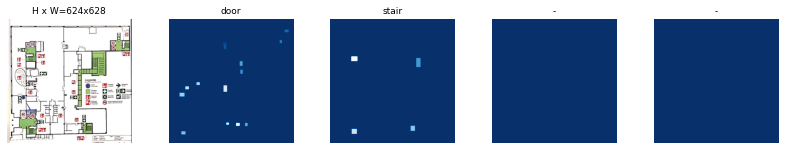

polygon
polygon
polygon
polygon
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect


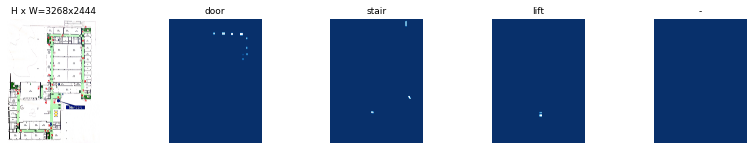

polygon
polygon
polygon
polygon
polygon
polygon
polygon
polygon
polygon
polygon
polygon
rect
rect
rect
rect
polygon
polygon
polygon
polygon
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
polygon
polygon
polygon
polygon
polygon


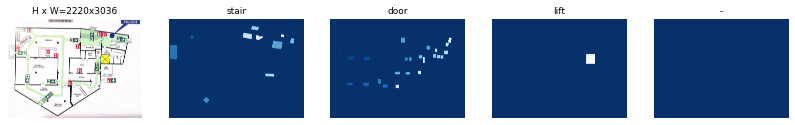

rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect


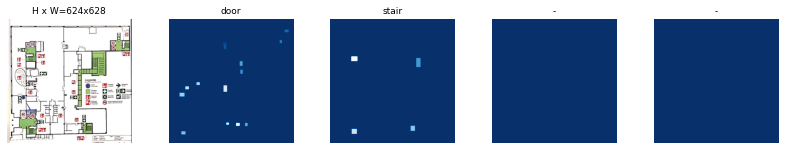

In [14]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


CREATE MODEL

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [16]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

TRAINING

In [0]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/barrier20200615T1325/mask_rcnn_barrier_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
polygon
polygon
polygon
polygon
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
polygon
polygon
polygon
polygon
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
polygon
polygon
polygon
polygon
polygon
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
polygon
rect
rect
rect
polygon
polygon
rect
polygon
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
polygon
polygon
polygon
polygon
polygon
rect
polygon
polygon
polygon
polygon
polygon
polygon
polygon
polygon
polygon
polygon
polygon
rect
rect
rect
rect
polygon
polygon
polygon
polygon
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect
rect

In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [0]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

DETECTION

In [0]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [0]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [0]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

EVALUATION

In [0]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))